# [IAFlash](https://entrepreneur-interet-general.etalab.gouv.fr/defis/2019/iaflash.html) simple exploration

## Data cleaning

Will work on the [Stanford Cars Dataset](http://ai.stanford.edu/~jkrause/cars/car_dataset.html). The data must be downloaded and present in the `pathToDataDir` directory.

### Imports

In [8]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/Dev/'))    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import pandas as pd
import time
import pickle

from PIL import Image, ImageOps, ImageFilter
# from skimage import filters as skf
import xml.etree.ElementTree

import matplotlib.pyplot as plt
%matplotlib inline

# from Pkg.helper import DataHandler, ImageWorker # needs correct working directory

### Variables

In [9]:
# data
if HOST == 'Arthurs-MacBook-Pro.local':
    pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/')
    pathToIntellDir = os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/Intelligence/')
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
# dh_train = DataHandler(pathToDataDir,whichList='train')

# image processing
edge = 2**7

# seed
np.random.seed(9)

### Data manipulations

In [6]:
import scipy.io # used to import .mat files with scipy.io.loadmat (see [here](https://stackoverflow.com/questions/874461/read-mat-files-in-python))

In [148]:
cars_annos = scipy.io.loadmat(pathToDataDir+'cars_annos.mat')
cars_annos_bbox = [(x[1][0,0],
                    x[2][0,0],
                    x[3][0,0],
                    x[4][0,0]) for x in cars_annos['annotations'][0,:]]
cars_annos_files = [x[0][0] for x in cars_annos['annotations'][0,:]]
cars_annos_labels = [x[5][0,0]-1 for x in cars_annos['annotations'][0,:]] # NB: change to 0-based index
cars_annos_istest = [1 == x[6][0,0] for x in cars_annos['annotations'][0,:]]
cars_annos_classnames = [x[0] for x in cars_annos['class_names'][0,:]]

In [149]:
for i in (30, 60, 90):
    print(cars_annos_bbox[i],
          cars_annos_files[i],
          cars_annos_labels[i],
          cars_annos_istest[i],
          cars_annos_classnames[cars_annos_labels[i]])

print((~np.array(cars_annos_istest)).sum())
print(np.array(cars_annos_istest).sum())

print(np.unique(np.array(cars_annos_istest)))
print(np.unique(np.array(cars_annos_labels)))

(125, 645, 1845, 1421) car_ims/000031.jpg 0 False AM General Hummer SUV 2000
(31, 12, 270, 160) car_ims/000061.jpg 0 True AM General Hummer SUV 2000
(104, 183, 842, 608) car_ims/000091.jpg 1 False Acura RL Sedan 2012
8144
8041
[False  True]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 

In [152]:
# I DONT GET THIS ONE: cars_test_annos_withlabels.mat 

cars_annos_test = scipy.io.loadmat(pathToDataDir+'cars_test_annos_withlabels.mat')
cars_annos_test_files = [x[5][0] for x in cars_annos_test['annotations'][0,:]]
cars_annos_test_bbox = [(x[0][0,0],
                         x[1][0,0],
                         x[2][0,0],
                         x[3][0,0]) for x in cars_annos_test['annotations'][0,:]]
cars_annos_test_labels = [x[4][0,0]-1 for x in cars_annos_test['annotations'][0,:]] # NB: change to 0-based index

In [153]:
for i in (30, 60, 90):
    print(cars_annos_test_bbox[i],
          cars_annos_test_files[i],
          cars_annos_test_labels[i],
          cars_annos_classnames[cars_annos_test_labels[i]])

(33, 107, 953, 610) 00031.jpg 163 Mercedes-Benz E-Class Sedan 2012
(3, 1, 291, 209) 00061.jpg 34 BMW M5 Sedan 2010
(47, 38, 259, 155) 00091.jpg 50 Cadillac CTS-V Sedan 2012


In [156]:
np.unique(np.array(cars_annos_test_labels))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

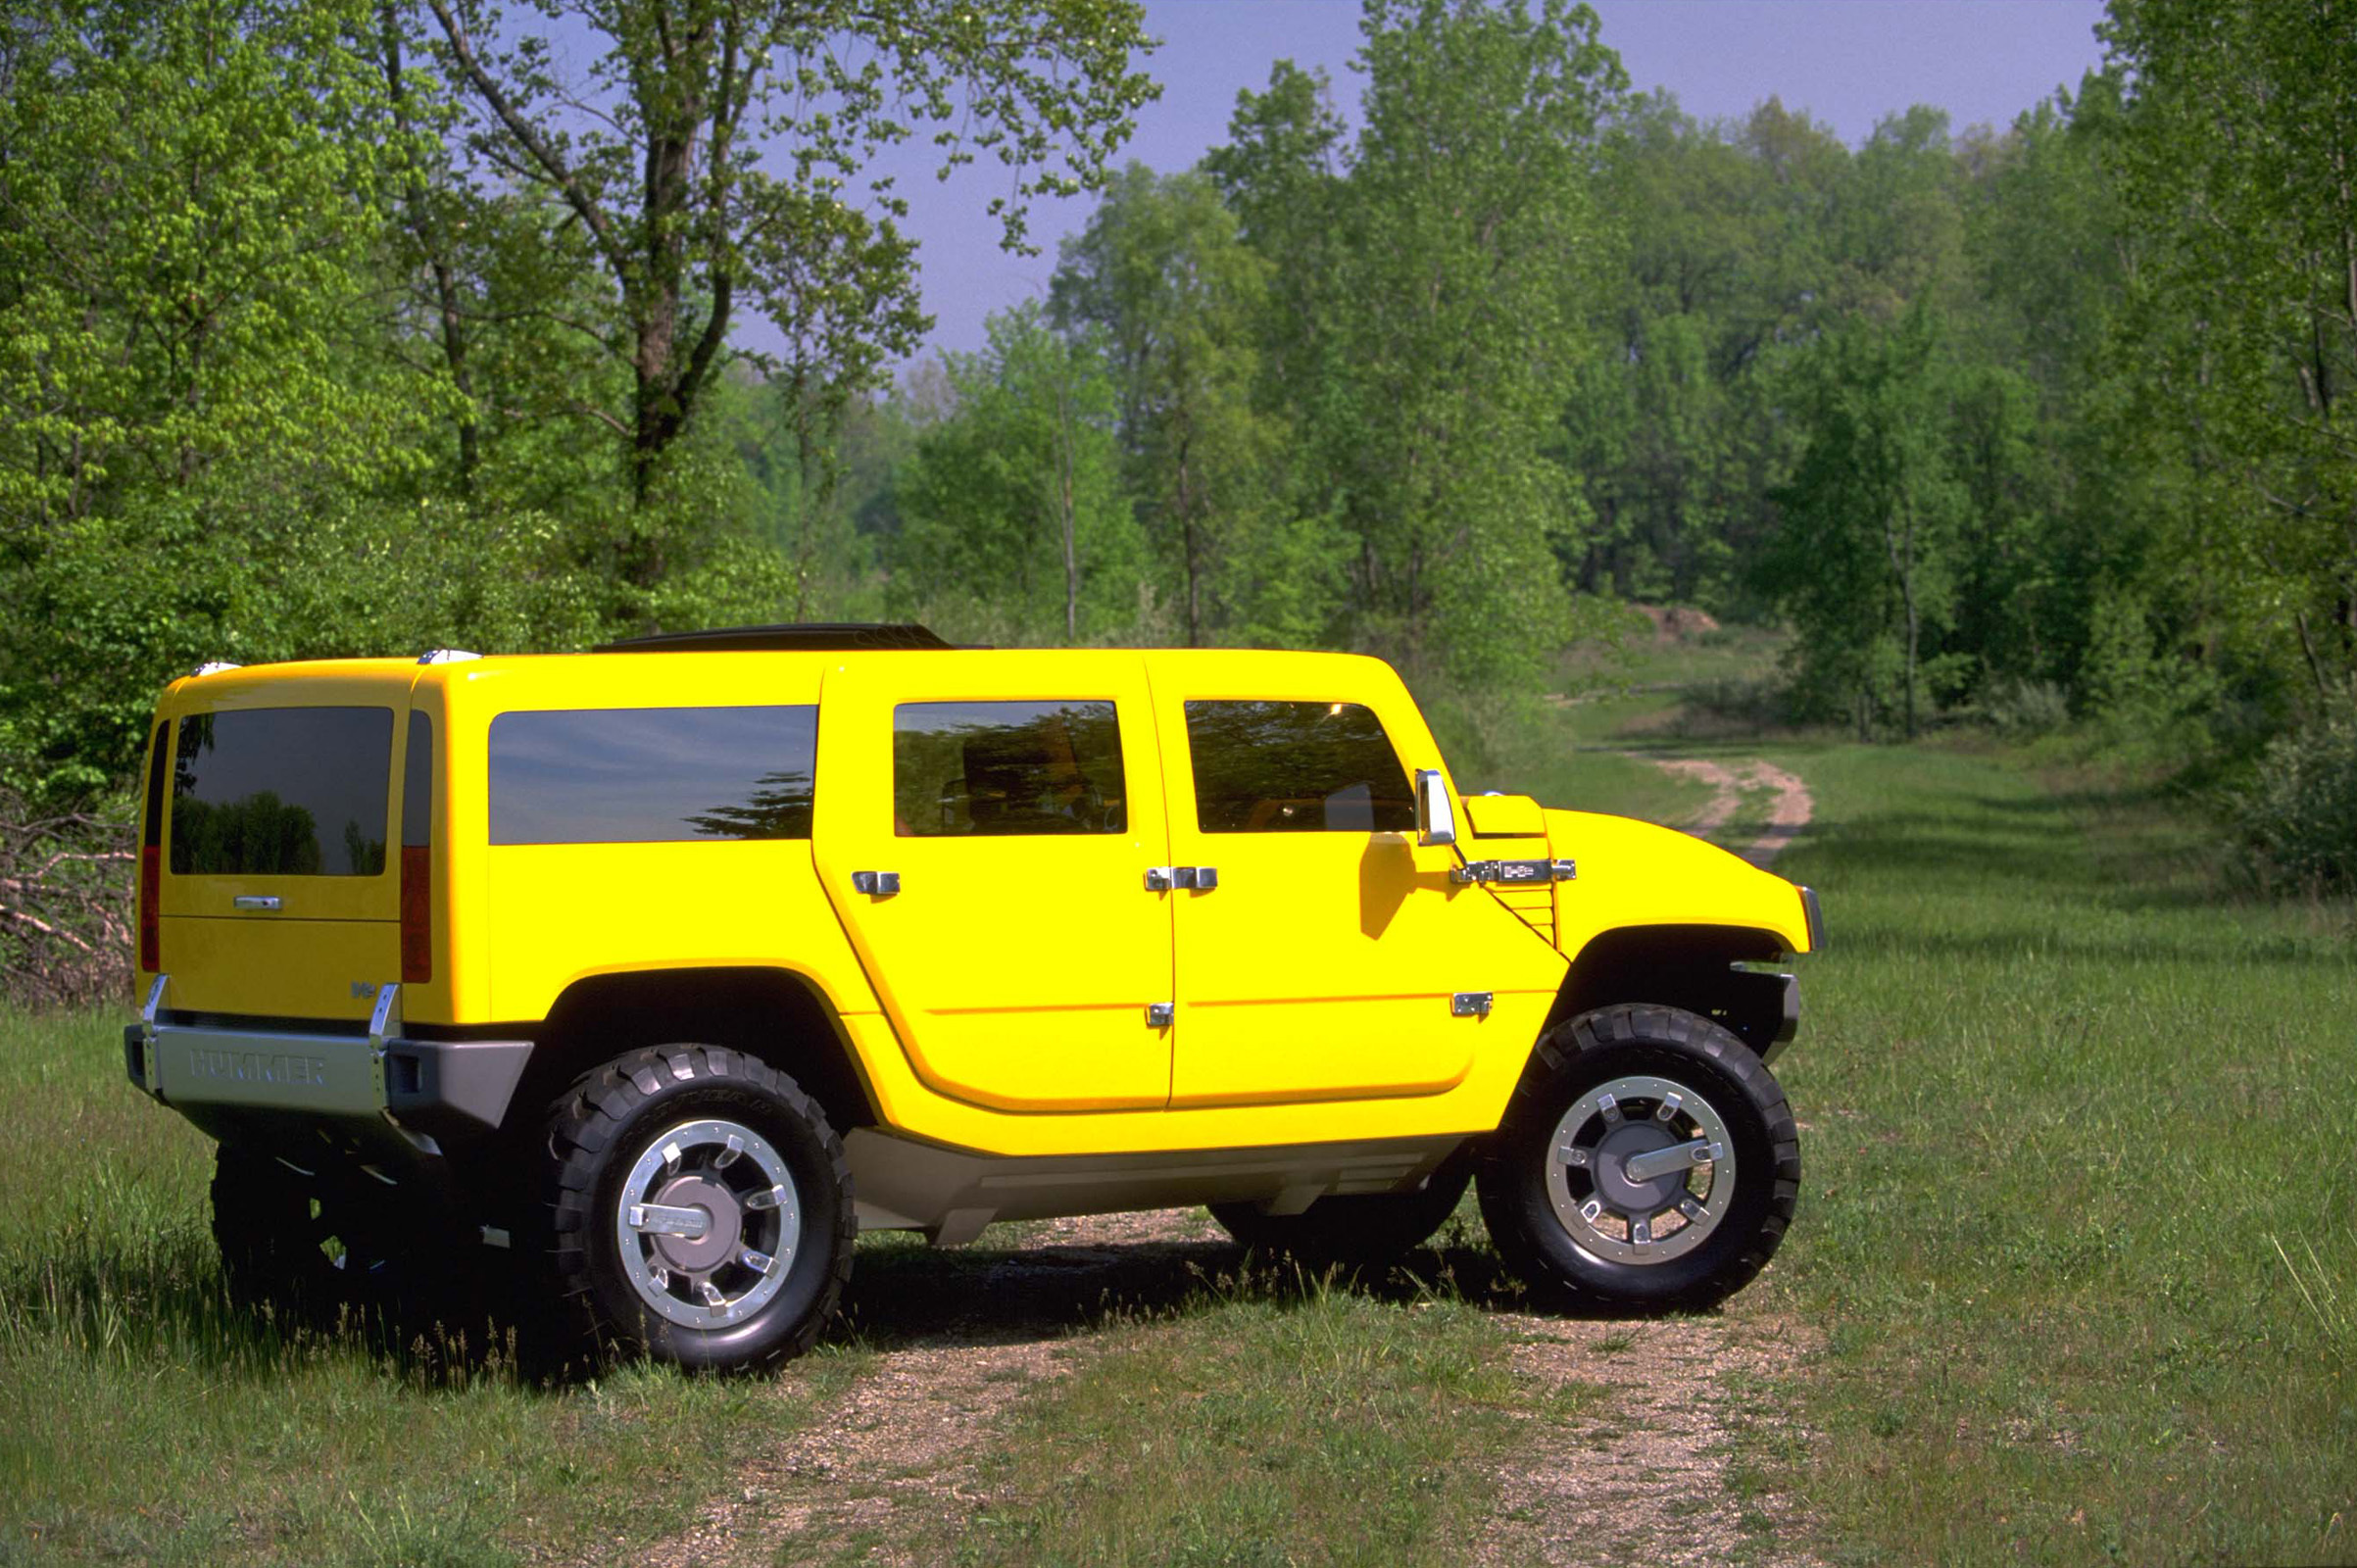

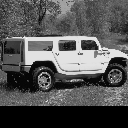

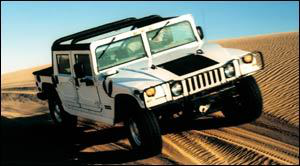

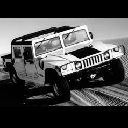

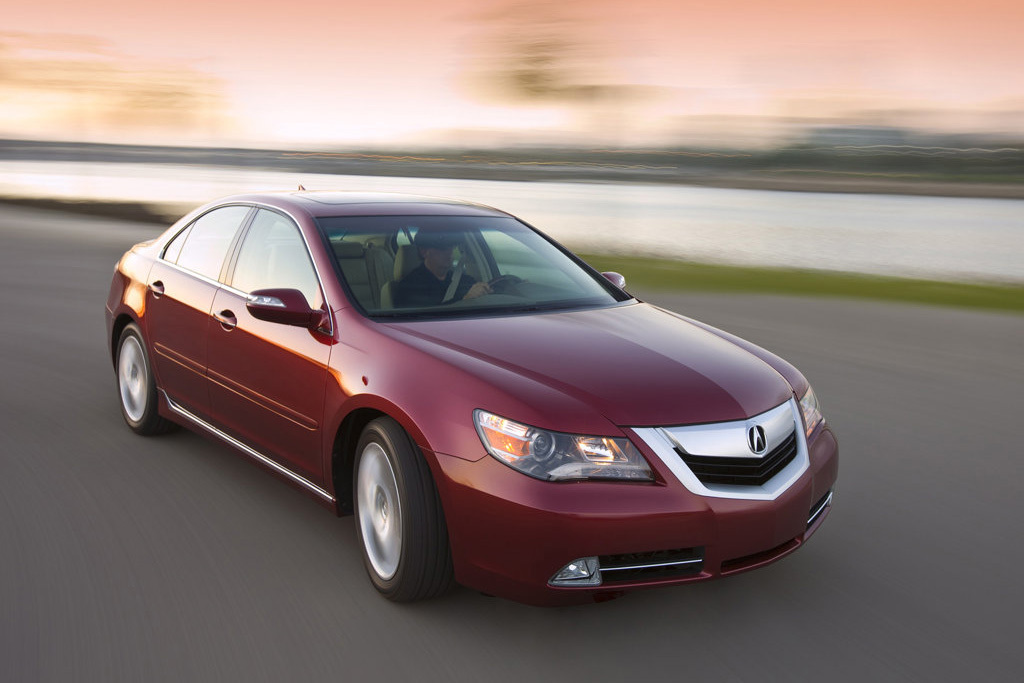

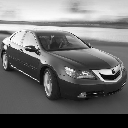

In [158]:
for i in (30, 60, 90):
    
    image = Image.open(pathToDataDir+cars_annos_files[i])
    display(image)

    # convert to black&white
    im_bw = image.convert('L')
    
    # change it to square with corresponding center
    [xmin,ymin,xmax,ymax] = cars_annos_bbox[i]

    xc,yc = int((xmax+xmin)/2),int((ymax+ymin)/2)
    halfedge = int(max((xmax-xmin)/2,(ymax-ymin)/2))

    box_square_centered = (xc-halfedge,
                           yc-halfedge,
                           xc+halfedge,
                           yc+halfedge)
    im_crop = im_bw.crop(box_square_centered)
    im_patch = im_crop.resize((edge,edge))

    display(im_patch)

86 Doberman


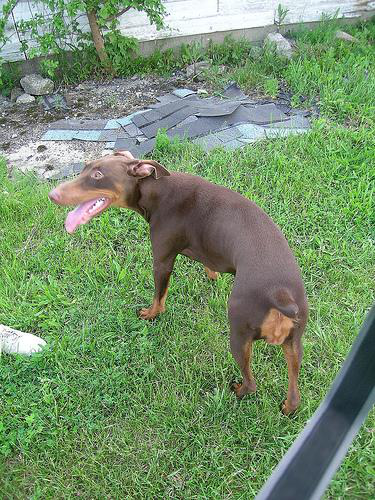

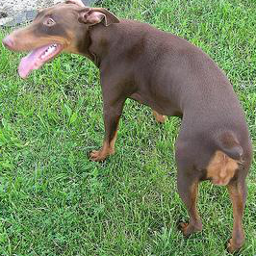

45 Boston_bull


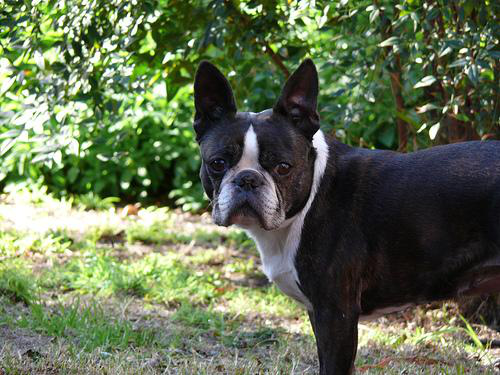

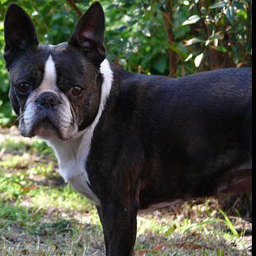

In [4]:
# crop images to centered squares

N = 2
for i in np.random.choice(dh_train.n,N):

    # load image & annotation
    iw = ImageWorker(dh_train,i)

    # create all patches
    iw.buildPatches(edge)

    print(iw.label,iw.labelName)
    display(iw.image)
    for _p in iw.patches:
        display(_p)

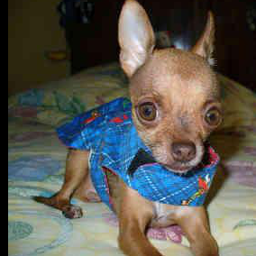

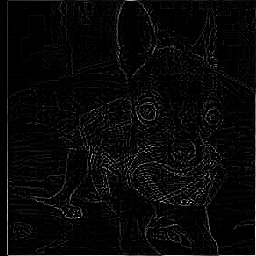

In [63]:
# OC lecture

i = 0
iw = ImageWorker(dh_train,i)
iw.buildPatches(edge)
im0 = iw.patches[0]

im = im0.copy()
im = im.convert('L')
im = ImageOps.equalize(im)
# im = im.filter(ImageFilter.GaussianBlur(4))
# im = im.filter(ImageFilter.FIND_EDGES)
# im = im.filter(ImageFilter.Kernel((3,3),(-1,0,1,
#                                          -2,0,2,
#                                          -1,0,1),1/8))
# im = im.filter(ImageFilter.Kernel((3,3),(-1,-2,-1,
#                                          0,0,0,
#                                          1,2,1),1/8))
im = im.filter(ImageFilter.Kernel((3,3),(0,1,0, # laplace
                                         1,-4,1,
                                         0,1,0),1))







display(im0)
display(im)

In [50]:
ImageFilter.Kernel?

# --- DRAFT

### Imports

### Data

In [6]:
if HOST == 'Arthurs-MacBook-Pro.local':
    pathToDataDir = HOME+'Documents/Dropbox/Transit/OCDataScienceData/Project6/Data/'    # @home
    pathToIntellDir = HOME+'Documents/Dropbox/Transit/OCDataScienceData/Project6/Intelligence/'    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))

In [7]:
# filename = 'QueryResults_10k.csv'
# df = pd.read_csv(pathToDataDir+filename,index_col='Id')

first = True
for i in range(1,8):
# for i in range(1,2):
    filename = 'QueryResults-{}.csv'.format(i)
    df_ = pd.read_csv(pathToDataDir+filename,index_col='Id')
    if first:
        df = df_.copy()
        first = False
    else:
        df = df.append(df_)

print(df.shape)

(174696, 3)


In [8]:
np.random.seed(8)

In [9]:
n,p = df.shape
k = .8
idx_train = np.random.choice((True,False),n,p=(k,1-k))
df_train,df_test = df.iloc[idx_train,:].copy(),df.iloc[~idx_train,:].copy()

In [10]:
print(df_train.shape,df_test.shape)
df_train.sample(5)

(140106, 3) (34590, 3)


Body  \
Id                                                          
696573  <p>I have a function getSlope which takes as p...   
46354   <p>I'm trying to perform a SQL query through a...   
607250  <p>I have a generic type that is parameterized...   
902017  <p>I saw a program(RAPGET) which downloads a f...   
399538  <p>I'm building a C++ application and need to ...   

                                                    Title  \
Id                                                          
696573  Unexpected loss of precision when dividing dou...   
46354   "Invalid column name" error on SQL statement f...   
607250  How do I get the type object of a genericized ...   
902017   Data from web-page to a text box in application?   
399538  How do I link PDCurses to a C++ application on...   

                                             Tags  
Id                                                 
696573                   <c++><double><precision>  
46354                           <sql><sql-server>  
607250                           <java><generics>  
902017                                      <vb6>  
399538  <c++><windows><linker><ncurses><pdcurses>

### Basic text cleaning

In [11]:
def applyCleaner(df,tokenizer,stopwords,stemer):
    '''
    applies the cleaner to a pd.DataFrame. See called functions for help.
    '''
    for c in ('Body','Title'):
        df[c+'_clean'] = df[c].apply(lambda x: basicHTMLTextCleaner(x,tokenizer,stopwords,stemer))
    for c in ('Tags',):
        df[c+'_clean'] = df[c].apply(lambda x: basicTagTextCleaner(x))
        
    return df

In [12]:
# define the potential tokens (to be used with RegexpTokenizer(gaps=False))
rex = ''
rex += '\.?'          # token can start by a dot
rex += '[a-zA-Z]+'    # then a word in letters
rex += '[0-9#+]*'     # then potentially numbers or some symbols

In [13]:
stopwords = set(nltk.corpus.stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(rex,gaps=False)
stemer = nltk.PorterStemmer()

tic = time.time()
df_train = applyCleaner(df_train,tokenizer,stopwords,stemer)
df_test = applyCleaner(df_test,tokenizer,stopwords,stemer)
print('done: took {}s'.format(np.round(time.time()-tic,2)))

done: took 651.01s


In [14]:
# save transformers for later
pickle.dump(stopwords, open(pathToIntellDir+'stopwords.pkl','wb'))
pickle.dump(tokenizer, open(pathToIntellDir+'tokenizer.pkl','wb'))
pickle.dump(stemer, open(pathToIntellDir+'stemer.pkl','wb'))

In [15]:
df_train.sample(5)

Body  \
Id                                                          
598041  <p>I have a stored procedure that returns a la...   
791030  <p>Say my database tables have columns like <c...   
577209  <p>I was creating a table in SQL Server CE and...   
929495  <p>I'm using the Code::Blocks IDE with GCC/Min...   
593905  <p>Could anybody help me to rename database in...   

                                                    Title  \
Id                                                          
598041             Querying results of a stored procedure   
791030  Should I store Enum ID/values in the database ...   
577209         Why doesn't SQL Server CE support varchar?   
929495                            Why is MinGW very slow?   
593905                            rename database in psql   

                                         Tags  \
Id                                              
598041       <sql><stored-procedures><sybase>   
791030       <c#><database><enums><constants>   
577209                        <sql-server-ce>   
929495  <c++><performance><mingw><codeblocks>   
593905                           <postgresql>   

                                               Body_clean  \
Id                                                          
598041  store procedur return larg number result would...   
791030  say databas tabl column like usertyp salestyp ...   
577209  creat tabl sql server ce realiz support varcha...   
929495  use code block ide gcc mingw window tri build ...   
593905  could anybodi help renam databas postgresql li...   

                                 Title_clean  \
Id                                             
598041           queri result store procedur   
791030  store enum id valu databas c# enumer   
577209         sql server ce support varchar   
929495                            mingw slow   
593905                    renam databas psql   

                                   Tags_clean  
Id                                             
598041       <sql><stored-procedures><sybase>  
791030       <c#><database><enums><constants>  
577209                        <sql-server-ce>  
929495  <c++><performance><mingw><codeblocks>  
593905                           <postgresql>

### Vectorization

Resources
- [scikit tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) (also used in this [kaggle example](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words))

*Input texts:*

In [16]:
# count occurences (beware to fit the dictionary only on train data!)
# NB: deal with tags separately, as they basically need one-hot encoding
max_df = .3 # should be possible to push up to .1 given the low frequencies of the tags...
min_df = .01

V_body = 500 # 100 # 20 # 500
count_body = CountVectorizer(analyzer = 'word',   # entities to be counted
                             strip_accents = None,
                             preprocessor = None, # because we did it ourselves
                             lowercase = False,   # because we did it ourselves
                             stop_words = None,   # because we did it ourselves
                             tokenizer = None,    # because we did it ourselves
                             token_pattern = rex, # must rewrite the tokens!
                             max_df = max_df,     # perform additional stopword trimming 
                             min_df = min_df,     # drop too rare terms
                             max_features = V_body) 

count_body.fit(df_train['Body_clean'])

V_title = 100 # 20 # 5 # 100
count_title = CountVectorizer(analyzer = 'word',   # entities to be counted
                              strip_accents = None,
                              preprocessor = None, # because we did it ourselves
                              lowercase = False,   # because we did it ourselves
                              stop_words = None,   # because we did it ourselves
                              tokenizer = None,    # because we did it ourselves
                              token_pattern = rex, # must rewrite the tokens!
                              max_df = max_df,     # perform additional stopword trimming 
                              min_df = min_df,     # drop too rare terms
                              max_features = V_title) 

count_title.fit(df_train['Title_clean'])

# transform to vectors using the fitted dictionaries
body_train = count_body.transform(df_train['Body_clean'])
title_train = count_title.transform(df_train['Title_clean'])

body_test = count_body.transform(df_test['Body_clean'])
title_test = count_title.transform(df_test['Title_clean'])

In [17]:
print('\nvocab for body (length {}): {}'.format(len(count_body.vocabulary_),count_body.vocabulary_.keys()))
print('\nvocab for title (length {}): {}'.format(len(count_title.vocabulary_),count_title.vocabulary_.keys()))


vocab for body (length 500): dict_keys(['given', 'specif', 'valu', 'display', 'time', 'day', 'standard', 'way', 'web', 'server', 'abl', 'user', 'within', 'page', 'http', 'header', 'part', 'string', 'differ', '.net', 'queri', 'servic', 'return', 'type', 'via', 'public', 'static', 'db', 'new', 'execut', 'var', 'select', 'copi', 'work', 'get', 'result', 'set', 'store', 'data', 'mysql', 'look', 'person', 'defin', 'code', 'number', 'program', 'test', 'know', 'assembl', 'version', 'option', 'though', 'includ', 'specifi', 'main', 'x', 'e', 'f', 'n', 'doubl', 'int', 'case', 'catch', 'would', 'actual', 'start', 'stuff', 'system', 'build', 'script', 'configur', 'c', 'compil', 'bit', 'also', 'tri', 'order', 'around', 'still', 'come', 'top', 'everi', 'updat', 'tabl', 'throw', 'error', 'issu', 'api', 'c++', 'tell', 'miss', 'someth', 'relat', 'make', 'problem', 'much', 'idea', 'could', 'give', 'app', 'link', 'output', 'line', 'name', 'find', 'declar', 'fail', 'file', 'object', 'creat', 'check', 'ne

In [18]:
# use TF-IDF (beware to fit the IDF with train data!)
tfidf_body = TfidfTransformer(use_idf=True).fit(body_train)
tfidf_title = TfidfTransformer(use_idf=True).fit(title_train)

# transform using the fitted IDF
body2_train = tfidf_body.transform(body_train)
title2_train = tfidf_title.transform(title_train)

body2_test = tfidf_body.transform(body_test)
title2_test = tfidf_title.transform(title_test)

In [19]:
# save transformers for later use
pickle.dump(count_body, open(pathToIntellDir+'count_body.pkl','wb'))
pickle.dump(count_title, open(pathToIntellDir+'count_title.pkl','wb'))

pickle.dump(tfidf_body, open(pathToIntellDir+'tfidf_body.pkl','wb'))
pickle.dump(tfidf_title, open(pathToIntellDir+'tfidf_title.pkl','wb'))

In [20]:
body2_train[0,:]

<1x500 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [21]:
title2_train[0,:]

<1x97 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

*Target tags:*

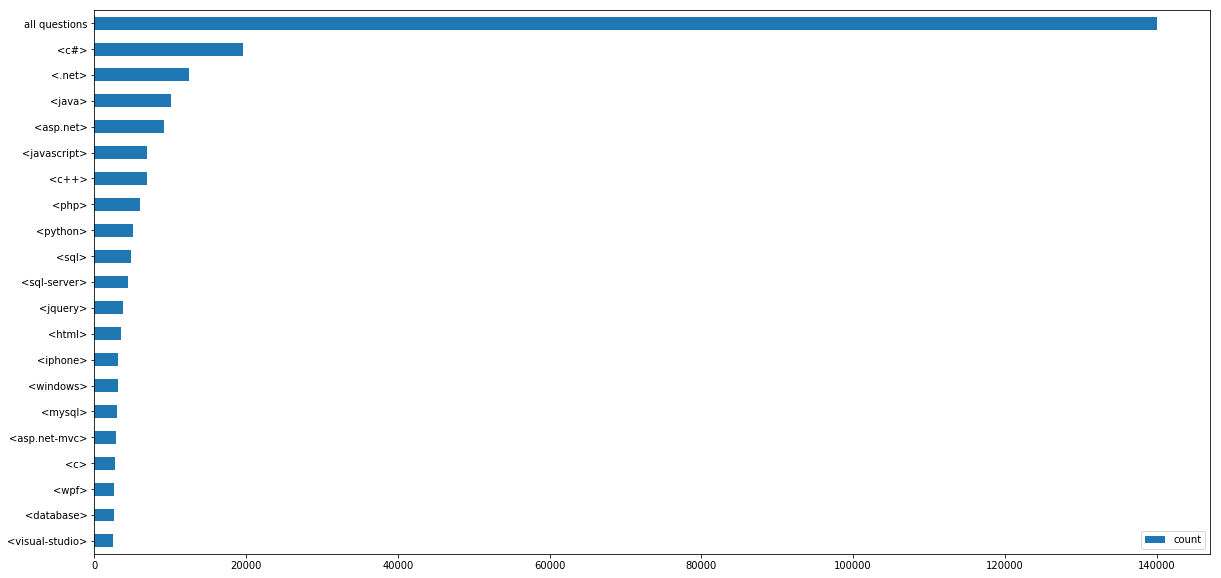

In [42]:
# analysis of the tags (NB: here we only 'multiplly'-one-hot encode: there is no need to compute TF-IDF!)

# count occurences
V_tag = 20
min_df_tag = .01 # we will only deal with not too rare tags

count_tag = CountVectorizer(analyzer = "word",   # entities to be counted
                            strip_accents = None,
                            preprocessor = None, # because we did it ourselves
                            lowercase = False,   # because we did it ourselves
                            stop_words = None,   # because we did it ourselves
                            tokenizer = None,    # because we did it ourselves
                            token_pattern = '<[^[<>]*>', # specific token for these tags
                            min_df = min_df_tag,
                            max_features=V_tag) 

count_tag.fit(df_train['Tags_clean'])

# transform
tag_train = count_tag.transform(df_train['Tags_clean'])
tag_test = count_tag.transform(df_test['Tags_clean'])

# plot number of questions per tag
tagCount = pd.DataFrame(index=['count'])
tagCount['all questions'] = tag_train.shape[0]
for t,i in count_tag.vocabulary_.items():
    tagCount[t] = tag_train[:,i].sum()
tagCount = tagCount.transpose()
tagCount = tagCount.sort_values(by='count',ascending=True)
tagCount.plot(kind='barh',figsize=(20,10))

In [43]:
print('\nvocab for tags (length {}): {}'.format(len(count_tag.vocabulary_),count_tag.vocabulary_.keys()))


vocab for tags (length 20): dict_keys(['<c#>', '<javascript>', '<html>', '<.net>', '<mysql>', '<database>', '<c++>', '<c>', '<sql>', '<sql-server>', '<php>', '<windows>', '<asp.net>', '<java>', '<python>', '<visual-studio>', '<wpf>', '<iphone>', '<asp.net-mvc>', '<jquery>'])


In [44]:
# save transofrmer for later use
pickle.dump(count_tag, open(pathToIntellDir+'count_tag.pkl','wb'))

In [45]:
tag_train[0,:].toarray()

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

*Merge together:*

In [46]:
x_train = hstack((body2_train,title2_train)) # need hstack because we work on sparse matrices...
x_test = hstack((body2_test,title2_test))

y_train = tag_train
y_test = tag_test

*Handle cases when some rows do not have selected words/tags...*

In [47]:
# SEE HOW TO AVOID THAT: go back to full matrices for subscripting, export...
x_train = x_train.toarray()
x_test = x_test.toarray()

y_train = y_train.toarray()
y_test = y_test.toarray()

In [48]:
isValid_train = isValidData(x_train,y_train,V_body)
isValid_test = isValidData(x_test,y_test,V_body)

print(np.array(isValid_train).mean())
print(np.array(isValid_test).mean())

x_train,y_train = x_train[isValid_train,:],y_train[isValid_train,:]
x_test,y_test = x_test[isValid_test,:],y_test[isValid_test,:]

0.571445905243
0.579531656548


In [49]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(80063, 597) (80063, 20)
(20046, 597) (20046, 20)


### Cleaned data

In [50]:
name = '100k'
np.savez(os.path.join(pathToDataDir,name+'_forLearning'), *[x_train,
                                                            x_test,
                                                            y_train,
                                                            y_test])